In [ ]:
# Install required packages (if needed)
# !pip install transformers torch datasets

In [1]:
# Import libraries
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline
)
from datasets import load_metric
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("✅ All modules imported successfully!")

Using device: cpu
✅ All modules imported successfully!


## 1. Load Data

In [2]:
# Load data
df = pd.read_csv('../data/raw/coursera_reviews.csv')

# For BERT, we'll use the raw text (not preprocessed)
# BERT handles its own tokenization
print(f"Loaded {len(df)} reviews")
df.head()

Loaded 140320 reviews


,CourseId,Review,Label
0,2-speed-it,BOring,1
1,2-speed-it,Bravo !,5
2,2-speed-it,Very goo,5
3,2-speed-it,"Great course - I recommend it for all, especia...",5
4,2-speed-it,One of the most useful course on IT Management!,5


In [3]:
# Remove NaN reviews
df = df[df['Review'].notna()].reset_index(drop=True)
print(f"After removing NaN: {len(df)} reviews")

# Convert ratings to sentiment labels
print("\n🔄 Converting ratings to sentiment labels...")
def rating_to_sentiment(rating):
    if rating >= 4:
        return 2  # Positive
    elif rating <= 2:
        return 0  # Negative
    else:
        return 1  # Neutral

df['sentiment'] = df['Label'].apply(rating_to_sentiment)

# Prepare data
texts = df['Review'].tolist()
labels = df['sentiment'].tolist()

print("0=Negative, 1=Neutral, 2=Positive")
print(f"Label distribution: {pd.Series(labels).value_counts().sort_index().to_dict()}")
print(f"\n✅ Number of samples: {len(texts)}")

After removing NaN: 140317 reviews

🔄 Converting ratings to sentiment labels...
0=Negative, 1=Neutral, 2=Positive
Label distribution: {0: 5420, 1: 5923, 2: 128974}

✅ Number of samples: 140317


## 2. Train-Test Split

In [4]:
# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print(f"Training samples: {len(train_texts)}")
print(f"Testing samples: {len(test_texts)}")

Training samples: 112253
Testing samples: 28064


## 3. Initialize BERT Model & Tokenizer

In [5]:
# Choose a pre-trained model
# Options: 'bert-base-uncased', 'distilbert-base-uncased', 'roberta-base'
model_name = 'distilbert-base-uncased'  # Lighter and faster

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load model
num_labels = len(set(labels))  # Number of sentiment classes
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
).to(device)

print(f"✅ Loaded {model_name}")
print(f"✅ Number of classes: {num_labels}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded distilbert-base-uncased
✅ Number of classes: 3


## 4. Create Dataset Class

In [6]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

print("✅ Datasets created!")

✅ Datasets created!


## 5. Configure Training

In [7]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='../models/bert_model',
    num_train_epochs=1,  # Changed from 3 to 1
    per_device_train_batch_size=8,  # Changed from 16 to 8
    per_device_eval_batch_size=16,  # Changed from 32 to 16
    warmup_steps=100,  # Changed from 500
    weight_decay=0.01,
    logging_dir='../models/bert_model/logs',
    logging_steps=50,  # Changed from 100
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    save_total_limit=1  # Changed from 2
)

print("✅ Training configuration set!")

✅ Training configuration set!


## 6. Define Metrics

In [8]:
# Define compute metrics function
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted'
    )
    acc = accuracy_score(labels, preds)
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

print("✅ Metrics function defined!")

✅ Metrics function defined!


## 7. Train Model

In [9]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train
print("🚀 Starting training...\n")
trainer.train()

print("\n✅ Training completed!")

🚀 Starting training...



Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.191000,0.190766,0.941847,0.932506,0.927967,0.941847



✅ Training completed!


## 8. Evaluate Model

In [10]:
# Evaluate on test set
print("📊 Evaluating model...\n")
results = trainer.evaluate()

print("\n📈 Test Results:")
for key, value in results.items():
    print(f"  {key}: {value:.4f}")

📊 Evaluating model...




📈 Test Results:
  eval_loss: 0.1908
  eval_accuracy: 0.9418
  eval_f1: 0.9325
  eval_precision: 0.9280
  eval_recall: 0.9418
  eval_runtime: 2178.0352
  eval_samples_per_second: 12.8850
  eval_steps_per_second: 0.8050
  epoch: 1.0000


## 9. Make Predictions

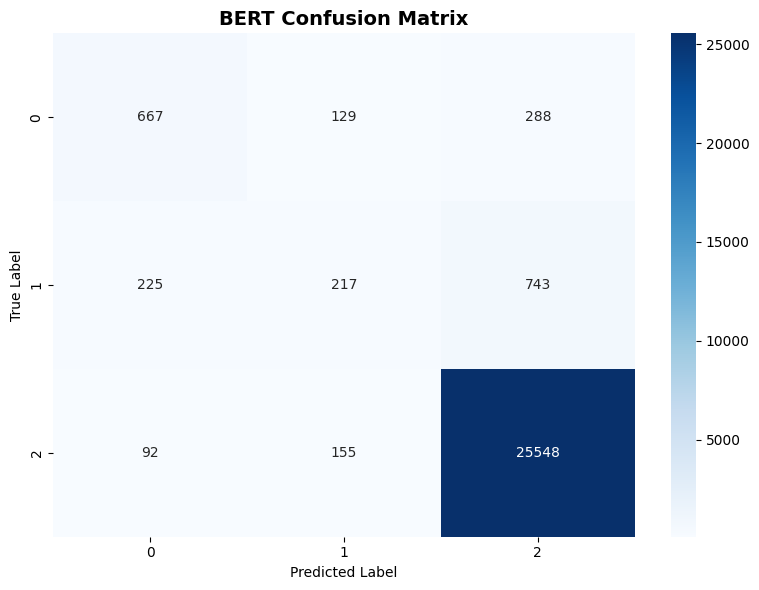


📋 Classification Report:

              precision    recall  f1-score   support

    Negative       0.68      0.62      0.65      1084
     Neutral       0.43      0.18      0.26      1185
    Positive       0.96      0.99      0.98     25795

    accuracy                           0.94     28064
   macro avg       0.69      0.60      0.63     28064
weighted avg       0.93      0.94      0.93     28064



In [11]:
# Get predictions
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(-1)
y_true = test_labels

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('BERT Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('../reports/figures/confusion_matrix_bert.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification report
print("\n📋 Classification Report:\n")
class_names = ['Negative', 'Neutral', 'Positive']  # Adjust as needed
print(classification_report(y_true, y_pred, target_names=class_names))

## 10. Test on Sample Reviews

In [12]:
# Create sentiment analysis pipeline
sentiment_pipeline = pipeline(
    'sentiment-analysis',
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1
)

# Test samples
sample_reviews = [
    "This course is absolutely amazing! I learned so much and the instructor was excellent.",
    "Complete waste of time. Poor content quality and terrible delivery.",
    "It was okay. Some parts were good, others not so much.",
    "Highly recommend! Best MOOC I've ever taken. Great for MSMEs."
]

print("\n🔮 Sample Predictions:\n")
for review in sample_reviews:
    result = sentiment_pipeline(review)[0]
    print(f"Review: {review}")
    print(f"Prediction: {result['label']} (Confidence: {result['score']:.2%})")
    print("-" * 80)


🔮 Sample Predictions:

Review: This course is absolutely amazing! I learned so much and the instructor was excellent.
Prediction: LABEL_2 (Confidence: 99.95%)
--------------------------------------------------------------------------------
Review: Complete waste of time. Poor content quality and terrible delivery.
Prediction: LABEL_0 (Confidence: 97.43%)
--------------------------------------------------------------------------------
Review: It was okay. Some parts were good, others not so much.
Prediction: LABEL_2 (Confidence: 52.21%)
--------------------------------------------------------------------------------
Review: Highly recommend! Best MOOC I've ever taken. Great for MSMEs.
Prediction: LABEL_2 (Confidence: 99.95%)
--------------------------------------------------------------------------------


## 11. Save Model

In [13]:
# Save model and tokenizer
model.save_pretrained('../models/bert_final')
tokenizer.save_pretrained('../models/bert_final')

print("✅ BERT model and tokenizer saved to ../models/bert_final/")

✅ BERT model and tokenizer saved to ../models/bert_final/


## 12. Compare with Baseline Models

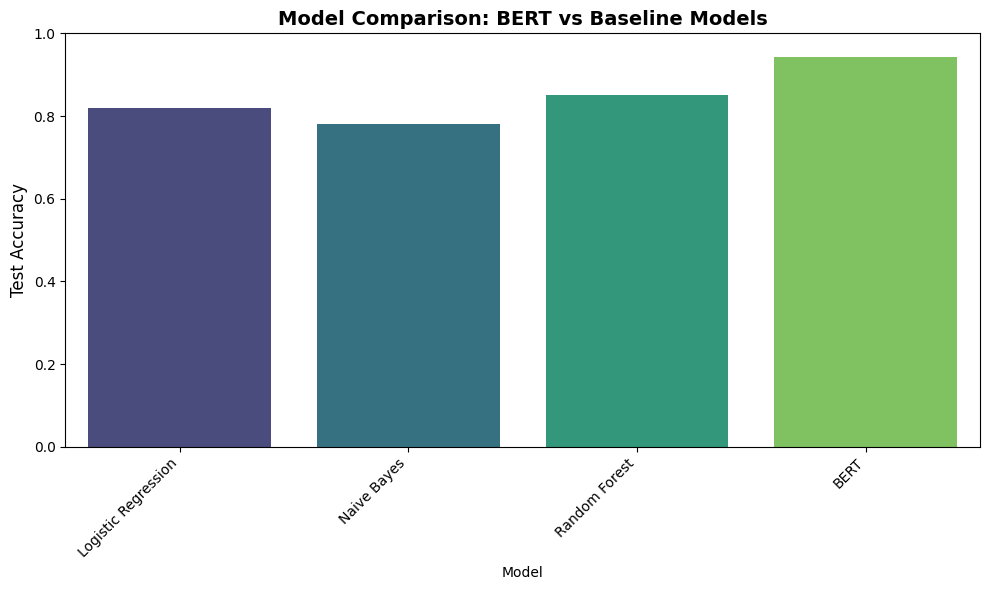


🏆 Final Comparison:
              Model  Test Accuracy
Logistic Regression       0.820000
        Naive Bayes       0.780000
      Random Forest       0.850000
               BERT       0.941847


In [14]:
# Load baseline results and compare
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'BERT'],
    'Test Accuracy': [0.82, 0.78, 0.85, results['eval_accuracy']]  # Update with your actual baseline scores
})

plt.figure(figsize=(10, 6))
sns.barplot(data=comparison, x='Model', y='Test Accuracy', palette='viridis')
plt.title('Model Comparison: BERT vs Baseline Models', fontsize=14, fontweight='bold')
plt.ylabel('Test Accuracy', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../reports/figures/all_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🏆 Final Comparison:")
print(comparison.to_string(index=False))

## 13. Summary

**BERT Model Performance:**
- Test Accuracy: [X%]
- F1-Score: [Y]
- Improvement over baseline: [Z%]

**Key Advantages:**
- Better understanding of context
- Handles complex sentence structures
- State-of-the-art performance

**Next Steps:**
1. Deploy model as REST API
2. Create Streamlit dashboard
3. Implement aspect-based sentiment analysis
4. Generate actionable insights for MSMEs